In [1]:
import pandas as pd
import os
from matplotlib import pyplot as plt
from datetime import datetime
# import emd
# from PyEMD import EMD

# 读取数据2018，2019

In [34]:
# df = pd.read_excel('./Measurements.xlsx', sheet_name=['Flows(m3_h)'], n_rows=1000)
path = './赛题数据/2018_BattLeDIM_Data_v1.1/2018 SCADA (CSV)/'
path19 = './赛题数据/2019_BattLeDIM_Data_v1.0/2019 SCADA (CSV)/'
file = 'Flows.csv'
file_demand = 'Demands.csv'
file_tank = 'Levels.csv'
df18 = pd.read_csv(os.path.join(path, file),
                     sep = ';',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp'
                    )
df19 = pd.read_csv(os.path.join(path19, file),
                     sep = ';',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp'
                    )
df_demand18 = pd.read_csv(os.path.join(path, file_demand),
                     sep = ';',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp'
                    )
df_demand19 = pd.read_csv(os.path.join(path19, file_demand),
                     sep = ';',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp'
                    )
df_level18 = pd.read_csv(os.path.join(path, file_tank),
                     sep = ';',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp'
                    )
df_level19 = pd.read_csv(os.path.join(path19, file_tank),
                     sep = ';',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp'
                    )
df = pd.concat([df18, df19])
df_demand = pd.concat([df_demand18, df_demand19])
df_level = pd.concat([df_level18, df_level19])

In [3]:
columns = ['p227', 'p235', 'PUMP_1']
def comma_to_point(x):
    return float(x.replace(',','.'))
for i in columns:
    df[i] = df[i].apply(comma_to_point)
    
columns_dem = list(df_demand18.columns)
for j in columns_dem:
    df_demand[j] = df_demand[j].apply(comma_to_point)
    
df_level = df_level['T1'].apply(comma_to_point)

In [4]:
df_demand['sum'] = df_demand[columns_dem].fillna(0).sum(axis=1)
# df_level.head(10000).plot()

# 趋势项分解

In [5]:
freq = 24*12
from statsmodels.tsa.seasonal import seasonal_decompose
def analyse(df):
    freq = 24*12
    decomposition = seasonal_decompose(x=df.dropna(), model='additive', freq=freq)
    seasonal_day = decomposition.seasonal
    trend_day = decomposition.trend
    resi_day = decomposition.resid

    decomposition2 = seasonal_decompose(x=trend_day.dropna(), model='additive', freq=freq*7)
    seasonal_week = decomposition2.seasonal
    trend_week = decomposition2.trend
    resi_week = decomposition2.resid
    return trend_week

df1 = df['p235']
trend_week1 = analyse(df1)
df2 = df['p227']
trend_week2 = analyse(df2)
df3 = df_demand['sum']
trend_demand = analyse(df3)

G:\Anaconda\envs\pytorch_env\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


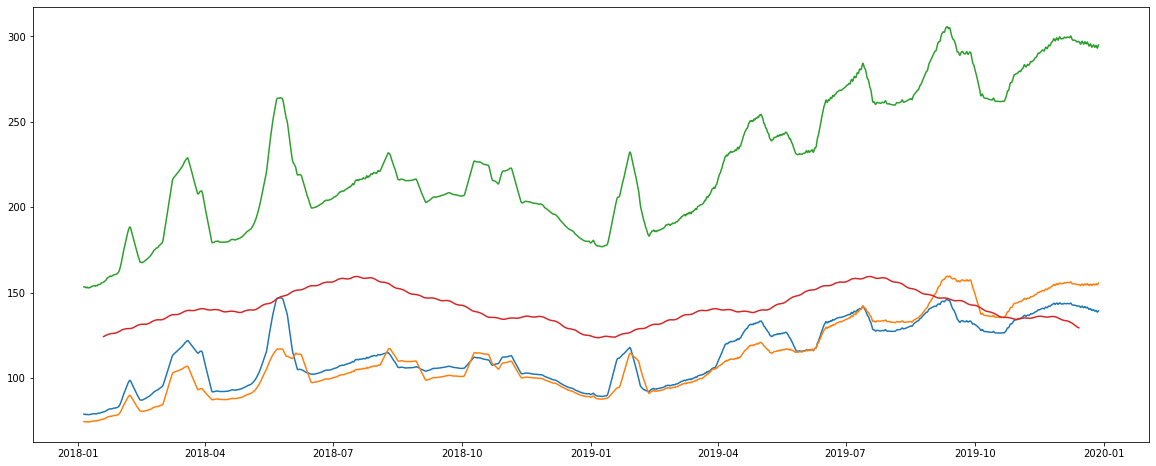

G:\Anaconda\envs\pytorch_env\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


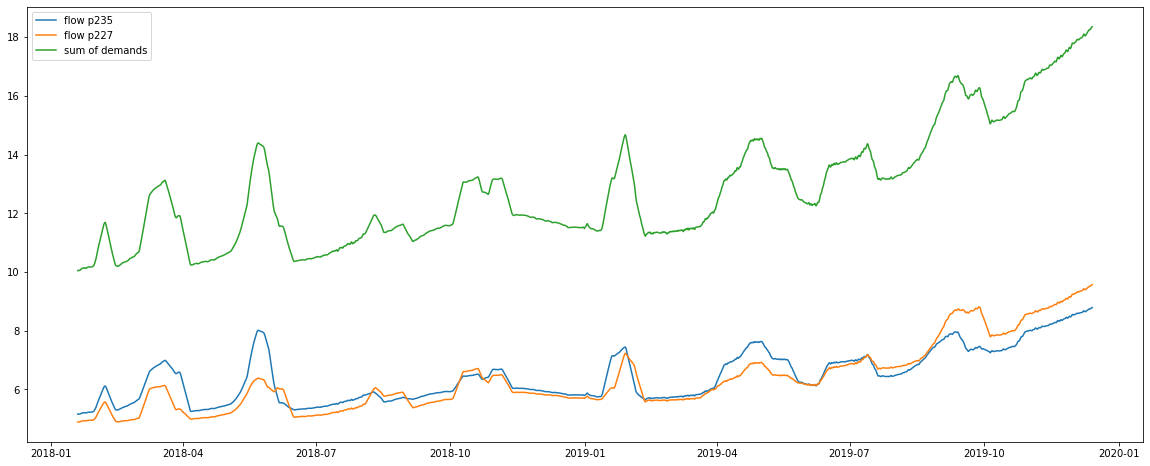

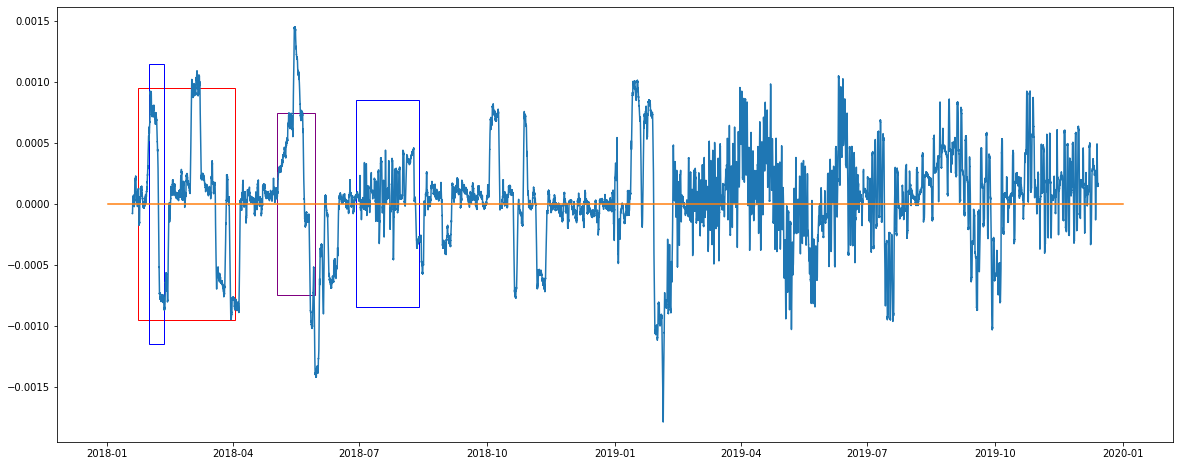

In [9]:
trend_demand_rolled = trend_demand.rolling(12*24*7*4, center=True).mean()

plt.figure(figsize=(20,8),facecolor='w')
plt.plot(trend_week1)
plt.plot(trend_week2)
plt.plot(trend_week1+trend_week2)
plt.plot(trend_demand_rolled/1000*8)

plt.figure(figsize=(20,8),facecolor='w')
plt.plot(trend_week1/trend_demand_rolled*1000)
plt.plot(trend_week2/trend_demand_rolled*1000)
plt.plot((trend_week1+trend_week2)/trend_demand_rolled*1000)

# plt.plot(trend_week1+trend_week2)
# plt.plot(trend_demand/1000*10.2)
# plt.plot(trend_week1-trend_week2)

# plt.figure(figsize=(20,5),facecolor='w')
# plt.plot(seasonal_week)
# plt.plot(trend_week)
# plt.plot(resi_week)
# plt.scatter(leakage, trend_week[leakage], c='red')
plt.legend(['flow p235','flow p227', 'sum of demands'])


plt.figure(figsize=(20,8),facecolor='w')
# plt.plot(trend_week1/trend_demand_rolled*1000)
# plt.plot(trend_week2/trend_demand_rolled*1000)
plt.plot(( (trend_week1+trend_week2)/trend_demand_rolled*1000).diff())
plt.plot([trend_week1.index[0],trend_week1.index[-1]], [0,0])
color_list = ['green','red','blue','black','orange','purple']
height_list = [0.0015,0.0019,0.0023,0.0017,0.0021]
start_list = [-i/2 for i in height_list]
ax = plt.gca()
for i in range(0, leakage_info.shape[0]):
    start = leakage_info.iloc[i]['Leak Start']
    timedelta = leakage_info.iloc[i]['Leak End'] - start
    leaktype = leakage_info.iloc[i]['Leak Type']
    if leaktype == ' incipient':
        DMA = leakage_info.iloc[i]['DMA']

        ax.add_patch(Rectangle( (start,start_list[i%5]), 
                               timedelta, height_list[i%5], 
                               fill=False, color=color_list[i%6]))

# 读取漏点

In [22]:
leakage_info = pd.read_excel('./WXT_2018-leakages.xlsx',
                            sheet_name='Sheet3')
leakage_info.head(5)

,Leak Pipe,Leak Area,Leak Diameter,Leak Type,Leak Start,Leak End,Peak Time,DMA
0,p257,0.000110,0.011843,incipient_unfix,2018-01-08 13:30:00,2018-12-31 23:55:00,2018-01-25 08:30:00,C
1,p461,0.000357,0.021320,incipient,2018-01-23 04:25:00,2018-04-02 11:40:00,2018-03-27 20:35:00,A
2,p232,0.000318,0.020108,incipient,2018-01-31 02:35:00,2018-02-10 09:20:00,2018-02-03 16:05:00,A
3,p427,0.000065,0.009073,incipient_unfix,2018-02-13 08:25:00,2018-12-31 23:55:00,2018-05-14 19:25:00,A
4,p673,0.000412,0.022916,abrupt,2018-03-05 15:45:00,2018-03-23 10:25:00,2018-03-05 15:45:00,B


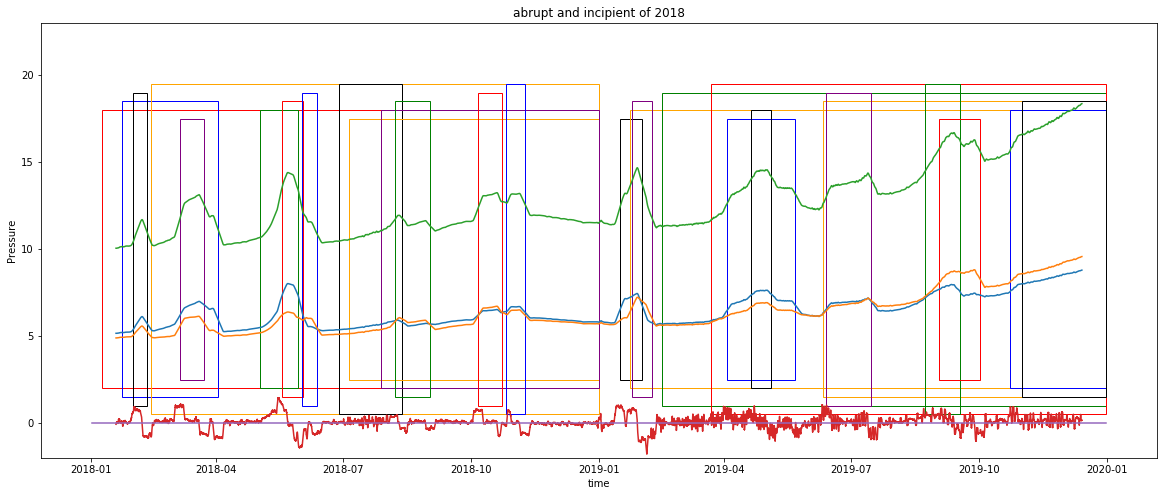

In [10]:
from matplotlib.patches import Rectangle
from datetime import timedelta
from matplotlib.collections import PatchCollection
leakage_info = pd.read_excel('./WXT_2018-leakages.xlsx',
                            sheet_name='Sheet3')
# plt.figure(facecolor='w',figsize=(20,2.5))
plt.figure(figsize=(20,8),facecolor='w')
plt.plot(trend_week1/trend_demand_rolled*1000)
plt.plot(trend_week2/trend_demand_rolled*1000)
plt.plot((trend_week1+trend_week2)/trend_demand_rolled*1000)

plt.plot(( (trend_week1+trend_week2)/trend_demand_rolled*1000).diff()*1000)
plt.plot([trend_week1.index[0],trend_week1.index[-1]], [0,0])

color_list = ['green','red','blue','black','orange','purple']
height_list = [15,16,17,18,19]
start_list = [(20-i)/2 for i in height_list]
ax = plt.gca()

m = 0
for i in range(0, leakage_info.shape[0]):
    start = leakage_info.iloc[i]['Leak Start']
    timedelta = leakage_info.iloc[i]['Leak End'] - start
    leaktype = leakage_info.iloc[i]['Leak Type']
    if leaktype != ' aincipient_unfix':
        m += 1
        DMA = leakage_info.iloc[i]['DMA']

        ax.add_patch(Rectangle( (start,start_list[m%5]), 
                               timedelta, height_list[m%5], 
                               fill=False, color=color_list[m%6]))
#     plt.text(start+timedelta/2, 19+8+height_list[i%5]+0.5, leaktype, ha='center', va= 'bottom',fontsize=7)
ax.set_ylim([-2, 23])
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('abrupt and incipient of 2018')
# plt.savefig('./abrupt and incipient of 2018 2019 vs flow.png', format='png',dpi=600)
plt.show()

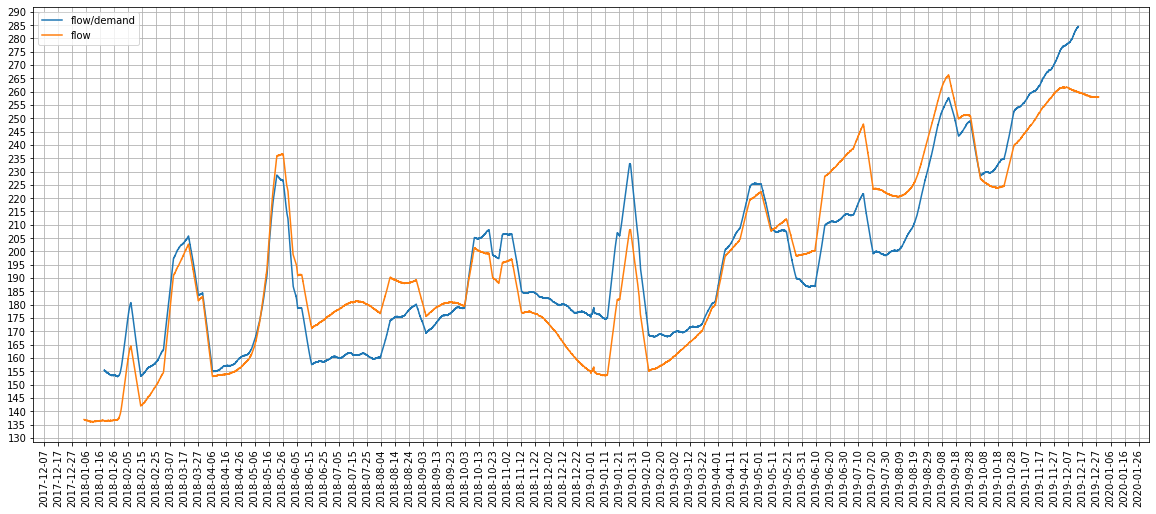

In [33]:
plt.figure(figsize=(20,8),facecolor='w')
# plt.plot(trend_week1/trend_demand_rolled*1000)
# plt.plot(trend_week2/trend_demand_rolled*1000)
myflow = (df['p227']+df['p235']-df['PUMP_1']).rolling(12*24*7, center=True).mean()
myflow2 = myflow/trend_demand_rolled*(trend_demand_rolled.mean())
plt.plot(myflow2)
plt.plot(myflow)
# plt.xticks()
# plt.plot(( (trend_week1+trend_week2)/trend_demand_rolled*1000).diff()*1000)
# plt.plot([trend_week1.index[0],trend_week1.index[-1]], [0,0])
import pylab as pl
import matplotlib.ticker as ticker
ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
plt.legend(['flow/demand','flow'])
plt.grid() 
# plt.savefig('./flow read incipient 2018 2019.png',format='png',dpi=600)

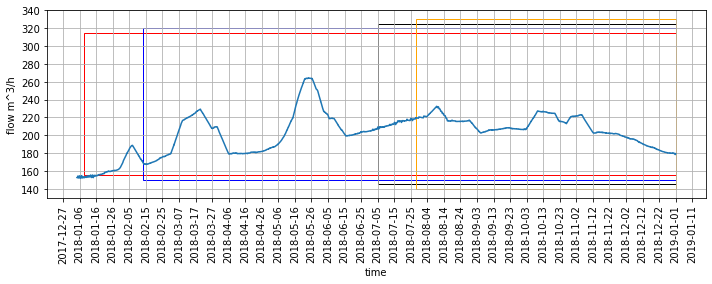

In [23]:
from matplotlib import pyplot as pl
plt.figure(figsize=(10,4),facecolor='w')
# /trend_demand_rolled*10000)
myflow = (df['p227']+df['p235']-df['PUMP_1']).rolling(12*24*7, center=True).mean()
myflow = myflow/trend_demand_rolled*(trend_demand_rolled.mean())

plt.plot( myflow.head(int(df.shape[0]/2)) )
ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

ax.yaxis.set_major_locator(ticker.MultipleLocator(20)) # 155-
plt.xlabel('time')
plt.ylabel('flow m^3/h')
# plt.savefig('./read incipient.png',format='png',dpi=600)

color_list = ['green','red','blue','black','orange','purple']
height_list = [150,160,170,180,190]
start_list = [(470-i)/2 for i in height_list]
ax = plt.gca()

m = 0
for i in range(0, leakage_info.shape[0]):
    start = leakage_info.iloc[i]['Leak Start']
    timedelta = leakage_info.iloc[i]['Leak End'] - start
    leaktype = leakage_info.iloc[i]['Leak Type']
    if leaktype == ' incipient_unfix':
        m += 1
        DMA = leakage_info.iloc[i]['DMA']

        ax.add_patch(Rectangle( (start,start_list[m%5]), 
                               timedelta, height_list[m%5], 
                               fill=False, color=color_list[m%6]))
plt.grid() 
plt.tight_layout()
plt.ylim([130, 340])
# plt.savefig('./read incipient 2018.png',format='png',dpi=600)

Text(0, 0.5, 'flow m^3/h')

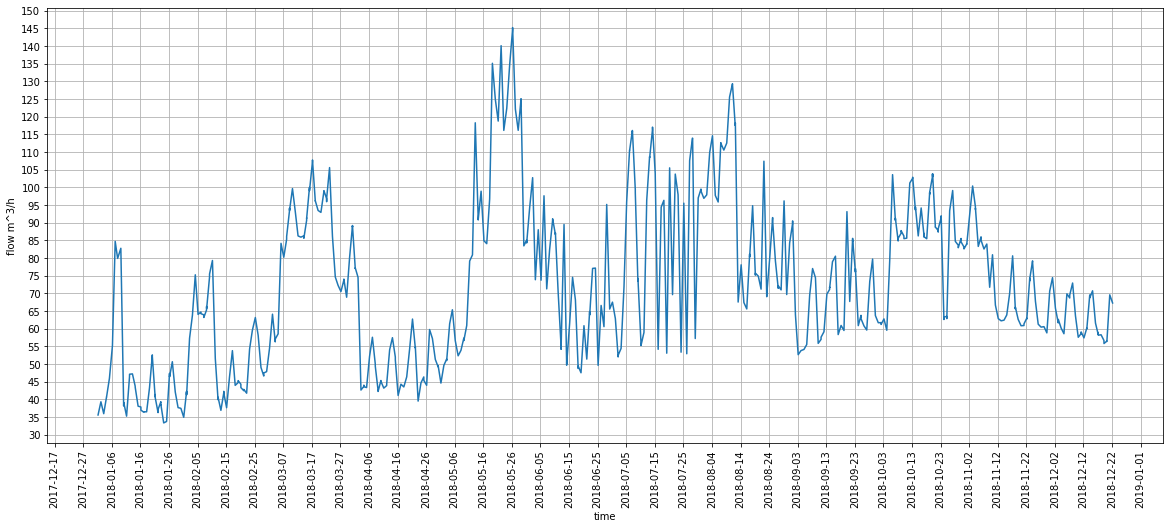

In [116]:
res_list = []
min_of_day = 12*24
for time in range(0,356):
    day = (df['p227']+df['p235']).iloc[time*min_of_day:(time+1)*min_of_day]
    daymini = day.min()
    res_list += [day[day<daymini+1]]
res_df = pd.concat(res_list)

plt.figure(figsize=(20,8),facecolor='w')
plt.plot(res_df)
ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid() 
ax.yaxis.set_major_locator(ticker.MultipleLocator(5)) # 155-
plt.xlabel('time')
plt.ylabel('flow m^3/h')
# plt.savefig('./read incipient.png',format='png',dpi=600)

# 2019年数据

In [29]:
path_19 = './赛题数据/2019_BattLeDIM_Data_v1.0/2019 SCADA (CSV)/'
file = 'Flows.csv'
df_19 = pd.read_csv(os.path.join(path_19, file),
                     sep = ';',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp'
                    )

In [30]:
columns = ['p227', 'p235', 'PUMP_1']
def comma_to_point(x):
    return float(x.replace(',','.'))
for i in columns:
    df_19[i] = df_19[i].apply(comma_to_point)

### 周期分解数据

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
def analyse(col):
    freq = 24*12
    decomposition = seasonal_decompose(x=df_19[col], model='additive', freq=freq)
    seasonal_day = decomposition.seasonal
    trend_day = decomposition.trend
    resi_day = decomposition.resid

    decomposition2 = seasonal_decompose(x=trend_day.dropna(), model='additive', freq=freq*7)
    seasonal_week = decomposition2.seasonal
    trend_week = decomposition2.trend
    resi_week = decomposition2.resid


    plt.figure(figsize=(20,5),facecolor='w')
    plt.plot(decomposition.seasonal)
    plt.plot(trend_day)
    plt.plot(resi_day)

    plt.figure(figsize=(20,5),facecolor='w')
    plt.plot(seasonal_week)
    plt.plot(trend_week)
    plt.plot(resi_week)
    plt.legend(['Periodic','Trend','Residul'])
    plt.title('Analyse of Flow of '+col+' in 2019')
    return trend_week

col = 'p235'
trend_week1 = analyse(col)
col = 'p227'
trend_week2 = analyse(col)

NameError: name 'df_19' is not defined

### 界定漏损时间

G:\Anaconda\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


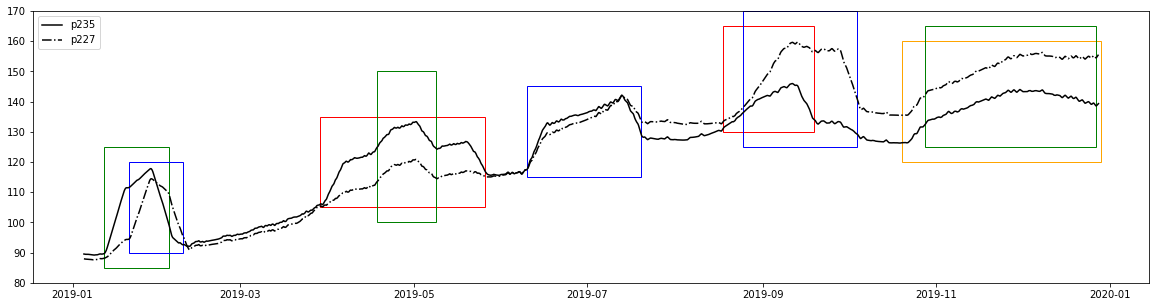

In [219]:
plt.figure(figsize=(20,5),facecolor='w')

from matplotlib.patches import Rectangle
from datetime import timedelta
from matplotlib.collections import PatchCollection
   
fig = plt.gcf()
ax = plt.gca()
ax.plot(trend_week1,'black')
ax.plot(trend_week2,'black',linestyle='-.')
ax.legend(['p235','p227'])
ax.set_ylim([80, 170])
# ax.add_patch(Rectangle((datetime(2019,1,12),85), timedelta(days=7), 30, fill=False, color='r'))
ax.add_patch(Rectangle((datetime(2019,1,12),85), timedelta(days=23), 40, fill=False, color='g'))
ax.add_patch(Rectangle((datetime(2019,1,21),90), timedelta(days=19), 30, fill=False, color='blue'))

ax.add_patch(Rectangle((datetime(2019,3,29),105), timedelta(days=58), 30, fill=False, color='r'))
ax.add_patch(Rectangle((datetime(2019,4,18),100), timedelta(days=21), 50, fill=False, color='g'))

ax.add_patch(Rectangle((datetime(2019,6,10),115), timedelta(days=40), 30, fill=False, color='blue'))

ax.add_patch(Rectangle((datetime(2019,8,18),130), timedelta(days=32), 35, fill=False, color='r'))
ax.add_patch(Rectangle((datetime(2019,8,25),125), timedelta(days=40), 45, fill=False, color='blue'))

ax.add_patch(Rectangle((datetime(2019,10,20),120), timedelta(days=70), 40, fill=False, color='orange'))
ax.add_patch(Rectangle((datetime(2019,10,28),125), timedelta(days=60), 40, fill=False, color='green'))

plt.savefig('./analyse2.png',format='png',dpi=1000)
plt.show()

### 3 sigma 算法

Text(0.5, 1.0, 'Analyse of Flow of p227 in 2019')

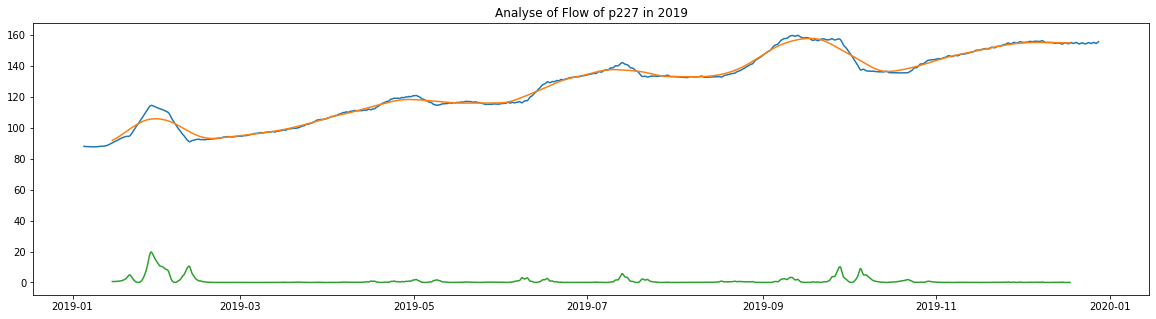

In [26]:
# trend_week2
rolling_trend = trend_week2.dropna().rolling(24*12*20, center=True).mean().dropna()
sigma = (trend_week2 - rolling_trend)**2
normalized_sigma = sigma/(sigma.mean())

plt.figure(figsize=(20,5),facecolor='w')
# plt.plot(seasonal_week)
plt.plot(trend_week2)
plt.plot(rolling_trend)
# plt.plot(normalized_sigma)
# plt.plot(resi_week)
# plt.legend(['Periodic','Trend','Residul'])
plt.title('Analyse of Flow of '+col+' in 2019')
# return trend_week

In [36]:
res = normalized_sigma[normalized_sigma>1]
res.rolling(10).mean().dropna()[::12*24].to_csv('./res.csv')
res.rolling(10).mean().dropna()[::12*24]

G:\Anaconda\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


Timestamp
2019-01-18 00:10:00    1.007594
2019-01-19 00:10:00    1.614115
2019-01-20 00:10:00    2.840386
2019-01-21 00:10:00    4.901165
2019-01-22 00:10:00    2.924164
                         ...   
2019-10-08 11:35:00    2.876188
2019-10-09 11:35:00    1.462765
2019-10-20 08:10:00    1.152169
2019-10-21 08:10:00    1.642526
2019-10-22 08:10:00    1.609107
Name: p227, Length: 69, dtype: float64

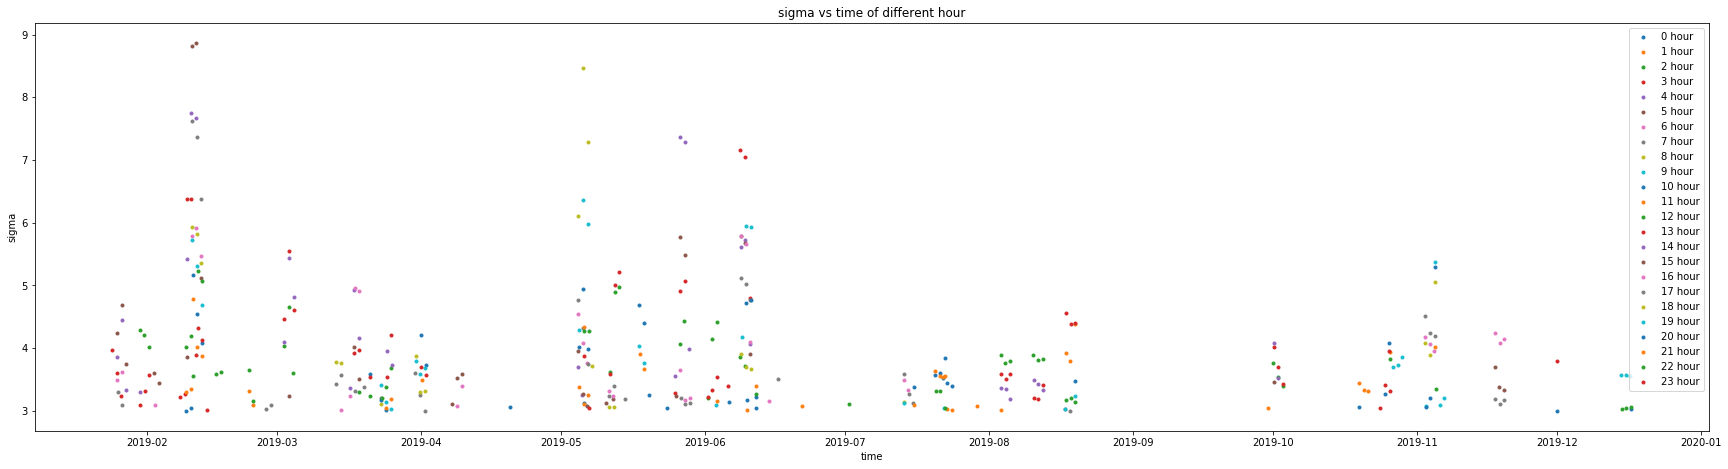

In [74]:
df_19[col]
df = df_19[col].rolling(12,center=True).mean()[::12]
plt.figure(figsize=(30,7.5),facecolor='w')
res_list = []
df_res = None
for i in range(0,24):
    df_hour = df.dropna()[i::24]
    df_hour_mean = df_hour.rolling(20, center=True).mean().dropna()
    sigma = (df_hour - df_hour_mean)**2
    sigma = sigma/(sigma.mean())
    sigma = sigma.rolling(3, center=True).mean()
    res = sigma[sigma>3]
    plt.scatter(res.index, res, marker='.')
    res_list += [res]
#     if df_res is None:
#         df_res = res
#     else:
#         df_res = df_res.join(res, how='outer')
        
plt.legend([str(i) + ' hour' for i in range(0,24)])
plt.ylabel('sigma')
plt.xlabel('time')
plt.title('sigma vs time of different hour')
# plt.savefig('./sigma vs time.png', format='png',dpi=1000)
plt.show()

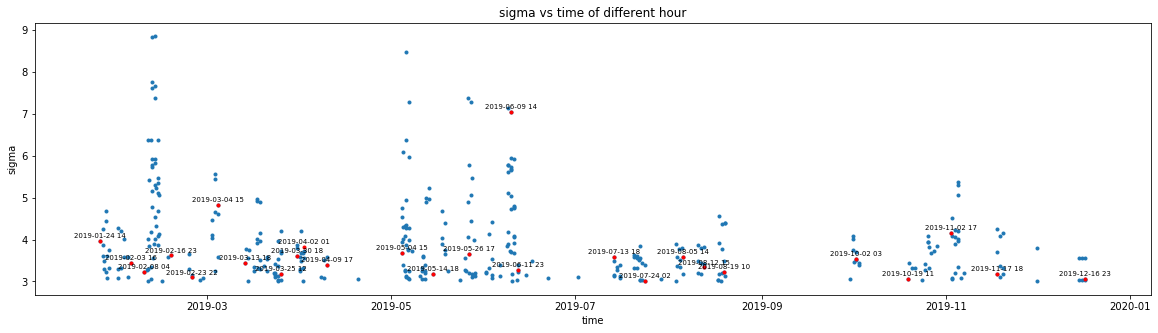

In [167]:
df_res = pd.concat(res_list)
df_res = df_res.sort_index()
plt.figure(figsize=(20,5), facecolor='w')
plt.scatter(df_res.index, df_res, marker='.')
i_list = [0,22,23,66,69,82,83,116,120,133,138,140,184,200,230,250,257,280,290,300,310,320,325,340,360,375]
for i in i_list:
    x = df_res.index[i]
    y = df_res[i]
    if i == 133:
        y += 0.1
    plt.scatter(x,y, marker='.',color='red')
    plt.text(x, y+0.05, str(x)[:-6], ha='center', va= 'bottom',fontsize=7)
plt.ylabel('sigma')
plt.xlabel('time')
plt.title('sigma vs time of different hour')
plt.savefig('./sigma vs time and text.png', format='png',dpi=1000)

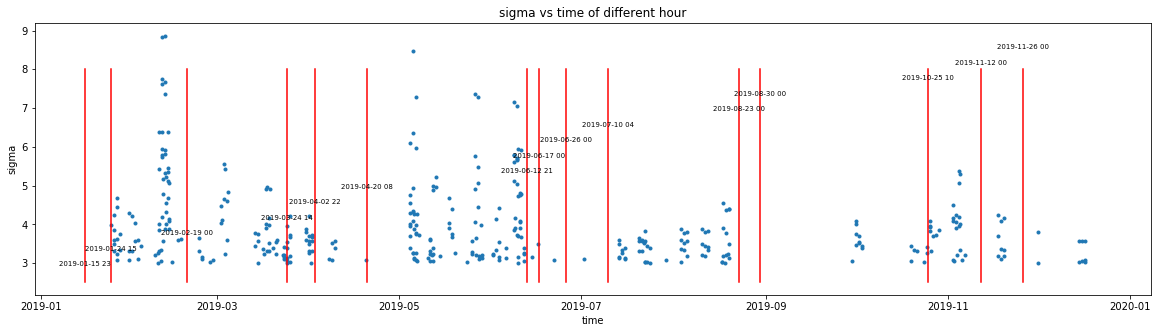

In [191]:
wxt_res = [datetime(2019,1,15,23,20,0),
           datetime(2019,1,24,15,50,0),
           datetime(2019,2,19,0,0,0),
           datetime(2019,3,24,14,0,0),
           datetime(2019,4,2,22,0,0),
           datetime(2019,4,20,8,30,0),
           datetime(2019,6,12,21,0,0),
           datetime(2019,6,17,0,0,0),
           datetime(2019,6,26,0,0,0),
           datetime(2019,7,10,4,30),
           datetime(2019,8,23,0,0,0),
           datetime(2019,8,30,0,0,0),
           datetime(2019,10,25,10,0,0),
           datetime(2019,11,12,0,0,0),
           datetime(2019,11,26,0,0,0),
          ]

df_res = pd.concat(res_list)
df_res = df_res.sort_index()
plt.figure(figsize=(20,5), facecolor='w')
plt.scatter(df_res.index, df_res, marker='.')
# i_list = [0,22,23,66,69,82,83,116,120,133,138,140,184,200,230,250,257,280,290,300,310,320,325,340,360,375]
y = 2.5
for i in wxt_res:
    x = i
    y +=0.4
#     y = df_res[i]
#     if i == 133:
#         y += 0.1
#     plt.scatter(x,y, marker='.',color='red')
    plt.plot([x,x],[2.5,8],'red')
    plt.text(x, y, str(x)[:-6], ha='center', va= 'bottom',fontsize=7)
plt.ylabel('sigma')
plt.xlabel('time')
plt.title('sigma vs time of different hour')
plt.savefig('./sigma vs time wxt.png', format='png',dpi=1000)

# 漏点和水量

G:\Anaconda\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


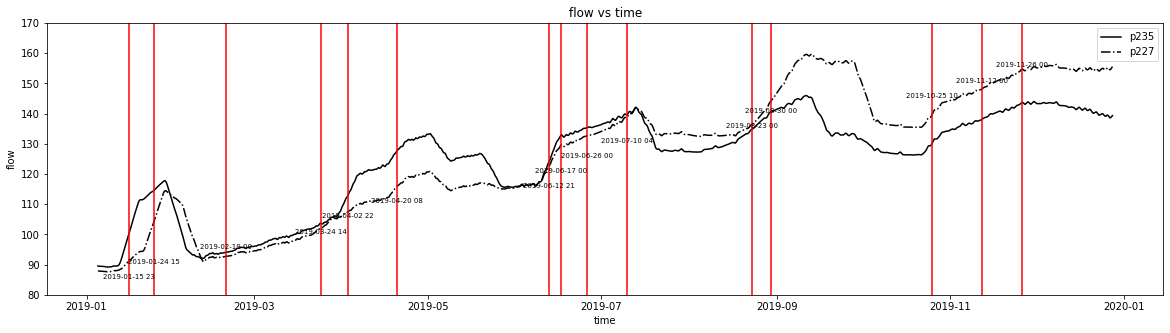

In [192]:
plt.figure(figsize=(20,5),facecolor='w') 
fig = plt.gcf()
ax = plt.gca()
ax.plot(trend_week1,'black')
ax.plot(trend_week2,'black',linestyle='-.')
ax.legend(['p235','p227'])
ax.set_ylim([80, 170])
y = 80
for i in wxt_res:
    x = i
    y +=5
    plt.plot([x,x],[80,170],'red')
    plt.text(x, y, str(x)[:-6], ha='center', va= 'bottom',fontsize=7)
plt.ylabel('flow')
plt.xlabel('time')
plt.title('flow vs time')
plt.savefig('./flow vs time wxt.png', format='png',dpi=1000)

# 画四个水量

In [2]:
import pandas as pd
import pylab as pl
import matplotlib.ticker as ticker
import matplotlib as mpl

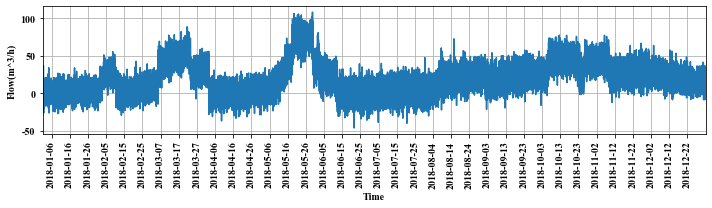

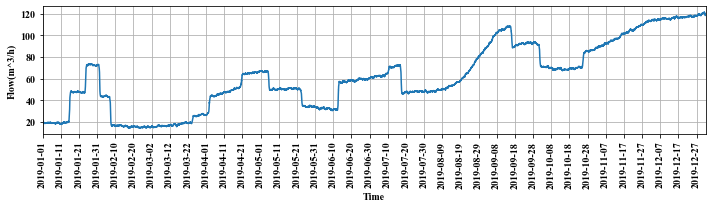

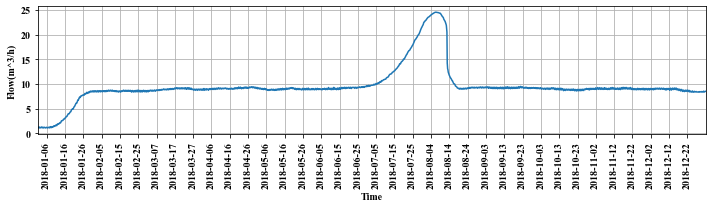

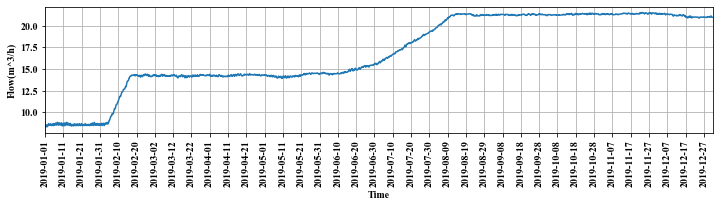

In [16]:
mpl.rcParams['agg.path.chunksize'] = 10000

# tb_c = pd.read_excel('./赛题数据/total_difference_table_c_2019.xlsx',
#                     sheet_name='Raw_data',
#                     parse_dates=['Timestamp'],
#                     index_col='Timestamp')
for tb in ['total_difference_table_ab_2018.xlsx','total_difference_table_ab_2019.xlsx',
           'total_difference_table_c_2018.xlsx','total_difference_table_c_2019.xlsx']:
    tb_c = pd.read_excel(os.path.join('./赛题数据/总分表差_对数变换/总分表差_对数变换', tb),
                    sheet_name='diff',
                    parse_dates=['Timestamp'],
                    index_col='Timestamp')
    plt.figure(figsize=(10,3),facecolor='w')
    plt.plot(tb_c[::2])
    ax = plt.gca()
    pl.xticks(rotation=90)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.grid() 
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(5)) # 155-
    plt.xlabel('Time')
    plt.ylabel('Flow(m^3/h)')
    plt.xlim([tb_c.index[0],tb_c.index[-1]])
    plt.tight_layout()
    plt.savefig('./'+tb+'.png',format='png',dpi=800)

# 画2018年水量和滑动平均

In [ ]:
tb_c = pd.read_excel(os.path.join('./赛题数据/总分表差_对数变换/总分表差_对数变换',
                                  'total_difference_table_ab_2018.xlsx',),
                    sheet_name='diff',
                    parse_dates=['Timestamp'],
                    index_col='Timestamp')

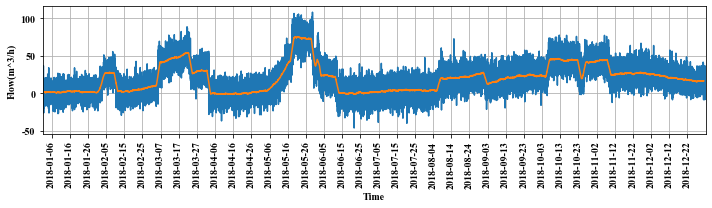

In [15]:
plt.figure(figsize=(10,3),facecolor='w')
plt.plot(tb_c[::2])
plt.plot(tb_c[::2].rolling(12*24, center=True).mean())
ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid() 
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(5)) # 155-
plt.xlabel('Time')
plt.ylabel('Flow(m^3/h)')
plt.xlim([tb_c.index[0],tb_c.index[-1]])
plt.tight_layout()
plt.savefig('./'+'total_difference_table_ab_2018.xlsx'+'.png',format='png',dpi=800)

# 画出水力学模型和实测值比较

In [ ]:
tb_c = pd.read_excel(os.path.join('./赛题数据/总分表差_对数变换/总分表差_对数变换',
                                  'total_difference_table_ab_2018.xlsx',),
                    sheet_name='demand_inflow',
                    parse_dates=['Timestamp'],
                    index_col='Timestamp')

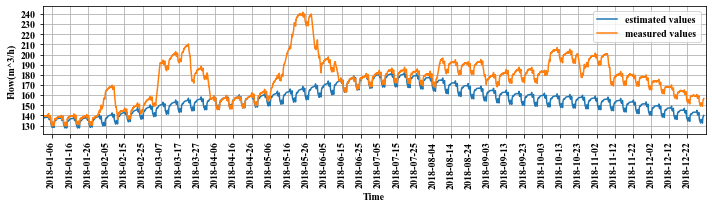

In [13]:
import matplotlib as mpl

mpl.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Times New Roman'],
    })  # 设置全局字体
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

plt.figure(figsize=(10,3),facecolor='w')
# plt.plot(tb_c[::2])
plt.plot(tb_c[::2].rolling(12*24, center=True).mean())
ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid() 
ax.yaxis.set_major_locator(ticker.MultipleLocator(10)) # 155-
plt.xlabel('Time')
plt.ylabel('Flow(m^3/h)')
plt.xlim([tb_c.index[0],tb_c.index[-1]])
plt.legend(['estimated values','measured values'])
plt.tight_layout()
plt.savefig('./'+'total_difference_table_ab_2018.xlsx'+'observ vs pred.png',format='png',dpi=800)

# 画出2019 A区流量

In [22]:
tb_ab = pd.read_excel('./赛题数据/total_difference_table_ab_2019.xlsx',
                     sheet_name='diff',
                     parse_dates=['Timestamp'],
                     index_col='Timestamp')

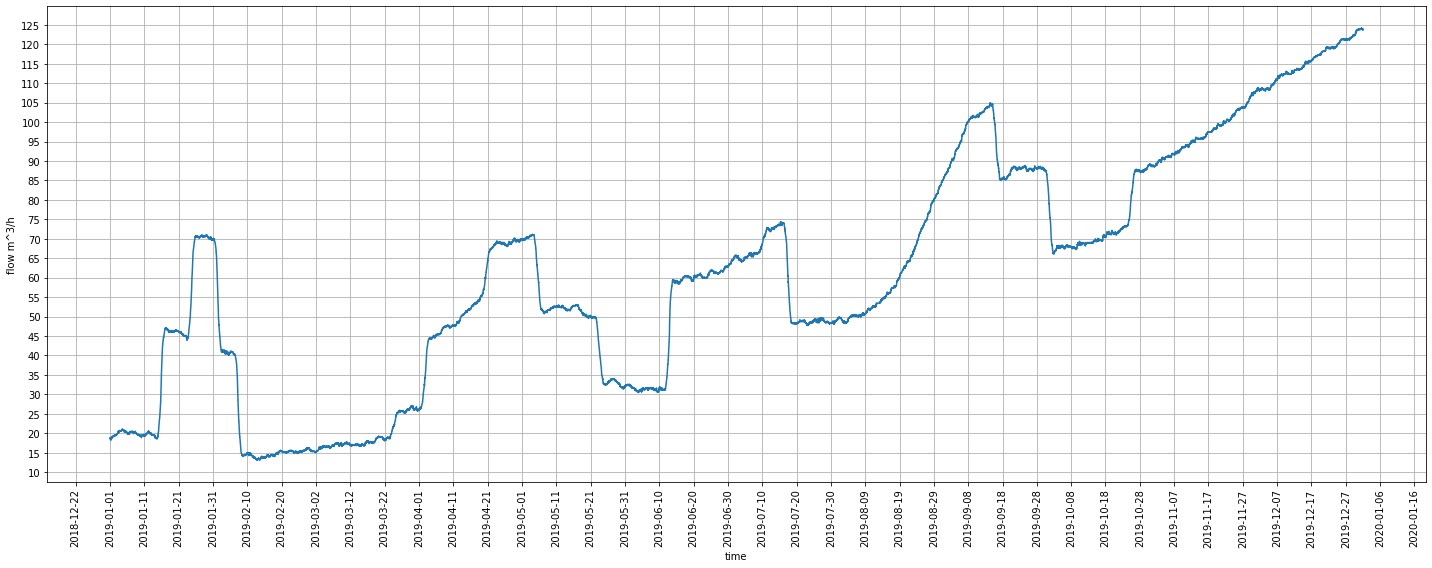

In [25]:
plt.figure(figsize=(20,8),facecolor='w')
plt.plot(tb_ab)
ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid() 
ax.yaxis.set_major_locator(ticker.MultipleLocator(5)) # 155-
plt.xlabel('time')
plt.ylabel('flow m^3/h')
plt.tight_layout()
plt.savefig('./xipeng2.png',format='png',dpi=1000)

# 画出2018,2019 demand总和

In [48]:
df_tre18 = pd.read_excel('./赛题数据/2018_BattLeDIM_Data_v1.1/2018 SCADA.xlsx', sheet_name='Demands (L_h)',
                        parse_dates=['Timestamp'],
                        index_col='Timestamp')
x1 = df_tre18.sum(axis=1)

In [40]:
df_tre19 = pd.read_excel('./赛题数据/2019_BattLeDIM_Data_v1.0/2019 SCADA.xlsx',
                         sheet_name='Demands (L_h)',
                        parse_dates=['Timestamp'],
                        index_col='Timestamp')
x2 = df_tre19.sum(axis=1)

In [65]:
freq = 24*12
from statsmodels.tsa.seasonal import seasonal_decompose
def analyse(df):
    freq = 24*12
    decomposition = seasonal_decompose(x=df, model='additive', freq=freq*7)
    seasonal_day = decomposition.seasonal
    trend_day = decomposition.trend
    resi_day = decomposition.resid

    decomposition2 = seasonal_decompose(x=trend_day.dropna(), model='additive', freq=freq)
    seasonal_week = decomposition2.seasonal
    trend_week = decomposition2.trend
    resi_week = decomposition2.resid
    return trend_week

y1 = analyse(x1)
y2 = analyse(x2)

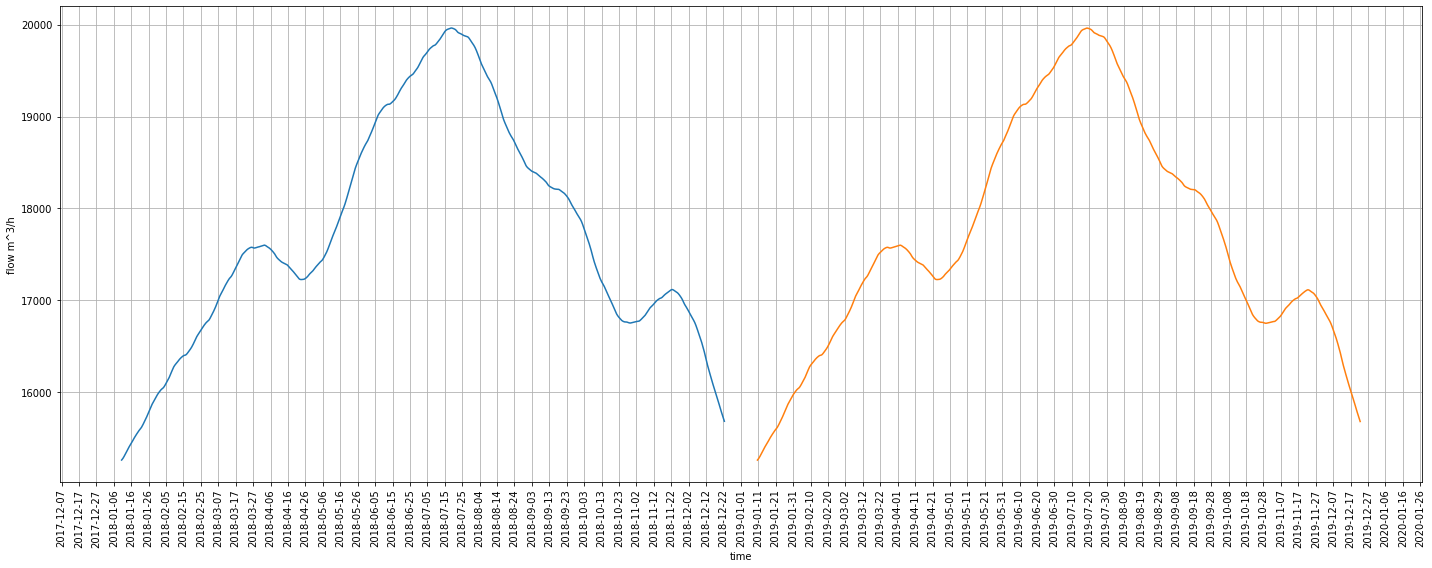

In [70]:
y11 = y1.rolling(12*24*11, center=True).mean()
y22 = y2.rolling(12*24*11, center=True).mean()

plt.figure(figsize=(20,8),facecolor='w')
plt.plot(y11)
plt.plot(y22)


ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid() 
# ax.yaxis.set_major_locator(ticker.MultipleLocator(5)) # 155-
plt.xlabel('time')
plt.ylabel('flow m^3/h')
plt.tight_layout()
plt.savefig('./trend 2018 2019 in DMA-C.png',format='png',dpi=1000)

In [71]:
y = pd.concat([y11, y22])

In [72]:
y.to_csv('./trend 2018 2019 in DMA-C.csv')

G:\Anaconda\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


# 滑动差分

In [18]:
cfdf = pd.read_excel('./滑动差分.xlsx',
                        #sheet_name='Demands (L_h)',
                        parse_dates=['Timestamp'],
                        index_col='Timestamp')

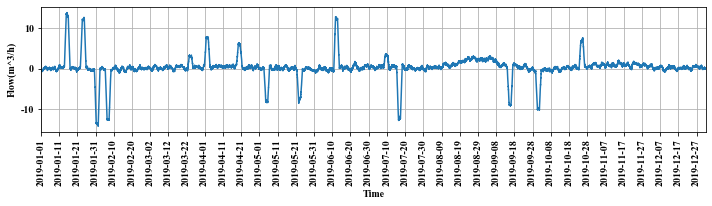

In [21]:
plt.figure(figsize=(10,3),facecolor='w')
plt.plot(cfdf)
# plt.plot(y22)
ax = plt.gca()
pl.xticks(rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid() 
# ax.yaxis.set_major_locator(ticker.MultipleLocator(5)) # 155-
plt.xlabel('Time')
plt.ylabel('Flow(m^3/h)')
plt.xlim([cfdf.index[0], cfdf.index[-1]])
plt.tight_layout()
plt.savefig('./滑动差分.png',format='png',dpi=1000)